In [124]:
import pickle

import numpy as np
import random
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import itertools

from math import isnan
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.cluster import v_measure_score, completeness_score, homogeneity_score
from scipy.stats import bootstrap
from scipy.stats import kruskal
from sklearn.metrics import silhouette_samples, adjusted_rand_score, silhouette_score

### Internal functions

In [42]:
def _silhouette_against_chance(y_pred, embeddings):
    # https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/02.5-make-projection-dfs/indv-id/marmoset-make-umap-get-silhouette-vs-chance.ipynb#L4
    emb_coefficients = silhouette_samples(embeddings, labels=y_pred)
    chance_coefficients = silhouette_samples(embeddings, labels=np.random.permutation(y_pred))
    krusk_res = kruskal(emb_coefficients, chance_coefficients)
    return krusk_res

In [123]:
def _silhouette_across_embeddings(y_pred_a, y_pred_b, embeddings):
    # https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/02.5-make-projection-dfs/indv-id/marmoset-make-umap-get-silhouette-vs-chance.ipynb#L4
    a_coefficients = silhouette_samples(embeddings, labels=y_pred_a)
    b_coefficients = silhouette_samples(embeddings, labels=y_pred_b)
    krusk_res = kruskal(a_coefficients, b_coefficients)
    return krusk_res

In [44]:
def _hopkins(X, random_seed):
    """
    Computes Hopkins statistic to avaluate clustering tendency of the dataset.
    
    Parameters:
        X (np.ndarray): The dataset to assess (n_samples, n_features).
        random_seed (int): Seed for random number generation for permutation.
    
    Returns:
        float: The Hopkins statistic (0 to 1). Values closer to 1 indicate clusters, 
               and values closer to 0 indicate uniform distribution.
    
    adapted from https://datascience.stackexchange.com/questions/14142/cluster-tendency-using-hopkins-statistic-implementation-in-python and https://matevzkunaver.wordpress.com/2017/06/20/hopkins-test-for-cluster-tendency/ accessed November 2024
    """
    # set seeds again to ensure 
    np.random.seed(random_seed)
    random.seed(random_seed)

    d = X.shape[1]
    n = len(X) # rows
    m = int(0.07 * n) # proportion of random subset
    nbrs = NearestNeighbors(n_neighbors=1).fit(X)
 
    rand_X = random.sample(range(0, n, 1), m)
 
    uid = []
    wid = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.uniform(np.amin(X,axis=0), np.amax(X,axis=0), d).reshape(1, -1), 2, return_distance=True)
        uid.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X[rand_X[j]].reshape(1, -1), 2, return_distance=True)
        wid.append(w_dist[0][1])
 
    H = sum(uid) / (sum(uid) + sum(wid))
    if isnan(H):
        print(uid, wid)
        H = 0

    return H

In [74]:
def _v_measure_against_chance(y_true, y_pred, n_permutations=1000, plot=True):
    n_permutations = 1000

    # true V-measure
    res_bootstrap_v = bootstrap((y_true, y_pred), v_measure_score, n_resamples=n_permutations, paired=True)

    true_v_measure = np.mean(res_bootstrap_v.bootstrap_distribution)
    ci_low, ci_high = res_bootstrap_v.confidence_interval.low, res_bootstrap_v.confidence_interval.high
    st_err = res_bootstrap_v.standard_error

    # null distribution of V-measure scores
    null_v_measures = []
    for _ in range(n_permutations):
        permuted_labels = np.random.permutation(y_pred)
        null_v_measures.append(v_measure_score(y_true, permuted_labels))

    # compute chance level as the mean of the null distribution
    chance_level = np.mean(null_v_measures)

    # compute p-value for the true V-measure
    p_value = np.mean([v >= true_v_measure for v in null_v_measures])

    # print(f"V-measure: {true_v_measure}")
    # print(f"Standard error: {st_err}")
    # print(f"Chance level: {chance_level}")
    # print(f"P-value: {p_value:.6f}")

    if plot:
        fig, ax = plt.subplots()
        ax.hist(null_v_measures, bins=20, density=True)
        ax.axvline(true_v_measure, ls="--", color="r")
        score_label = f"V-measure:: {true_v_measure:.3f}±{st_err:.4f}\n(p-value: {p_value:.6f})"
        ax.text(true_v_measure*1.1, 10, score_label, fontsize=12)
        ax.set_xlabel("Accuracy score")
        ax.set_ylabel("Probability density")
        plt.show()

    return true_v_measure, st_err, ci_low, ci_high, p_value, chance_level

In [46]:
def calculate_metrics_clustering(y_true, y_pred, data, representation_type, n_clusters, random_seed=42, plot=True):
    # https://scikit-learn.org/1.5/modules/generated/sklearn.metrics.v_measure_score.html
    
    result = {}
    result['n clusters'] = n_clusters

    if "embedding" in representation_type:
        hopkins = _hopkins(random_seed, data)
        result['Hopkins'] = hopkins
    else: 
        result['Hopkins'] = None
    
    sil_coeffs = silhouette_samples(data, y_pred)
    sil_score = np.mean(sil_coeffs)

    result['Silhouette score/Modularity'] = sil_score
    result['Silhouette coefficients'] = sil_coeffs

    res_bootstrap_h = bootstrap((y_true, y_pred), homogeneity_score, n_resamples=1000, paired=True)
    result['Homogeneity'] = np.mean(res_bootstrap_h.bootstrap_distribution)
    result['Homogeneity CI Low'] = res_bootstrap_h.confidence_interval.low
    result['Homogeneity CI High'] = res_bootstrap_h.confidence_interval.high
    result['Homogeneity Standard Error'] = res_bootstrap_h.standard_error

    res_bootstrap_c = bootstrap((y_true, y_pred), completeness_score, n_resamples=1000, paired=True)
    result['Completeness'] = np.mean(res_bootstrap_c.bootstrap_distribution)
    result['Completeness CI Low'] = res_bootstrap_c.confidence_interval.low
    result['Completeness CI High'] = res_bootstrap_c.confidence_interval.high
    result['Completeness Standard Error'] = res_bootstrap_c.standard_error

    true_v_measure, st_err, ci_low, ci_high, p_value, chance_level = _v_measure_against_chance(y_true, y_pred, plot=plot)
    result['V-measure'] = true_v_measure
    result['V-measure CI Low'] = ci_low
    result['V-measure CI High'] = ci_high
    result['V-measure Standard Error'] = st_err
    result['V-measure p-value'] = p_value
    result['V-measure Chance Level'] = chance_level

    res_bootstrap_rand = bootstrap((y_true, y_pred), adjusted_rand_score, n_resamples=1000, paired=True)
    result['Adjusted Rand Score'] = np.mean(res_bootstrap_rand.bootstrap_distribution)
    result['Adjusted Rand Score CI Low'] = res_bootstrap_rand.confidence_interval.low
    result['Adjusted Rand Score CI High'] = res_bootstrap_rand.confidence_interval.high
    result['Adjusted Rand Score Standard Error'] = res_bootstrap_rand.standard_error

    return result

### Load data

In [66]:
RANDOM_SEED = 42
random.seed(RANDOM_SEED)
np.random.RandomState(RANDOM_SEED)

RandomState(MT19937) at 0x1337A5640

In [67]:
with open("nn_graphs_embeddings_and_nn_graphs.pkl", "rb") as file:
    clusters_dict = pickle.load(file)

Mon Jan 20 20:46:23 2025 Building and compiling search function
Mon Jan 20 20:46:25 2025 Building and compiling search function
Mon Jan 20 20:46:26 2025 Building and compiling search function
Mon Jan 20 20:46:28 2025 Building and compiling search function


In [68]:
representation_keys = ["PAFs", "LFCCs", "Spectrograms", "VAE representations"]
algorithm_keys = ["kMeans", "kMeans-preset", "HDBSCAN", "Leiden"]

##### Hopkins statistic

In [86]:
rows = []
for representation in representation_keys:
    rows.append([representation, _hopkins(clusters_dict[representation]["embeddings"], RANDOM_SEED)])

hopkins_results = pd.DataFrame(
    rows, 
    columns=["Representation", "Hopkins"]
)

hopkins_results

,representation,Hopkins
0,PAFs,0.952433
1,LFCCs,0.901205
2,Spectrograms,0.966329
3,VAE representations,0.959001


##### Silhouette score and modularity

In [117]:
rows = []
for representation in representation_keys:
    for algorithm in algorithm_keys:
        if algorithm == "Leiden":
            rows.append([representation, algorithm, None, None, None, clusters_dict[representation]["Modularity"]])
            continue
        krusk_res = _silhouette_against_chance(clusters_dict[representation][algorithm], clusters_dict[representation]["embeddings"])
        rows.append([
            representation, 
            algorithm, 
            silhouette_score(clusters_dict[representation]["embeddings"], clusters_dict[representation][algorithm]),
            krusk_res.statistic, 
            krusk_res.pvalue, 
            None])

clusterability_results = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm", "Silhouette Score", "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value", "Modularity"]
)

clusterability_results

,Representation,Algorithm,Silhouette Score,Silhouette score - Kruskal statistic,Silhouette score - Kruskal p-value,Modularity
0,PAFs,kMeans,0.654991,3863.808526,0.0,NaN
1,PAFs,kMeans-preset,0.609897,3854.191977,0.0,NaN
2,PAFs,HDBSCAN,0.543932,2957.182260,0.0,NaN
3,PAFs,Leiden,NaN,NaN,NaN,0.772060
4,LFCCs,kMeans,0.654647,3859.315905,0.0,NaN
5,LFCCs,kMeans-preset,0.472572,3777.477155,0.0,NaN
6,LFCCs,HDBSCAN,0.654542,3861.484029,0.0,NaN
7,LFCCs,Leiden,NaN,NaN,NaN,0.681044
8,Spectrograms,kMeans,0.675608,3864.982662,0.0,NaN
9,Spectrograms,kMeans-preset,0.465843,3784.917197,0.0,NaN


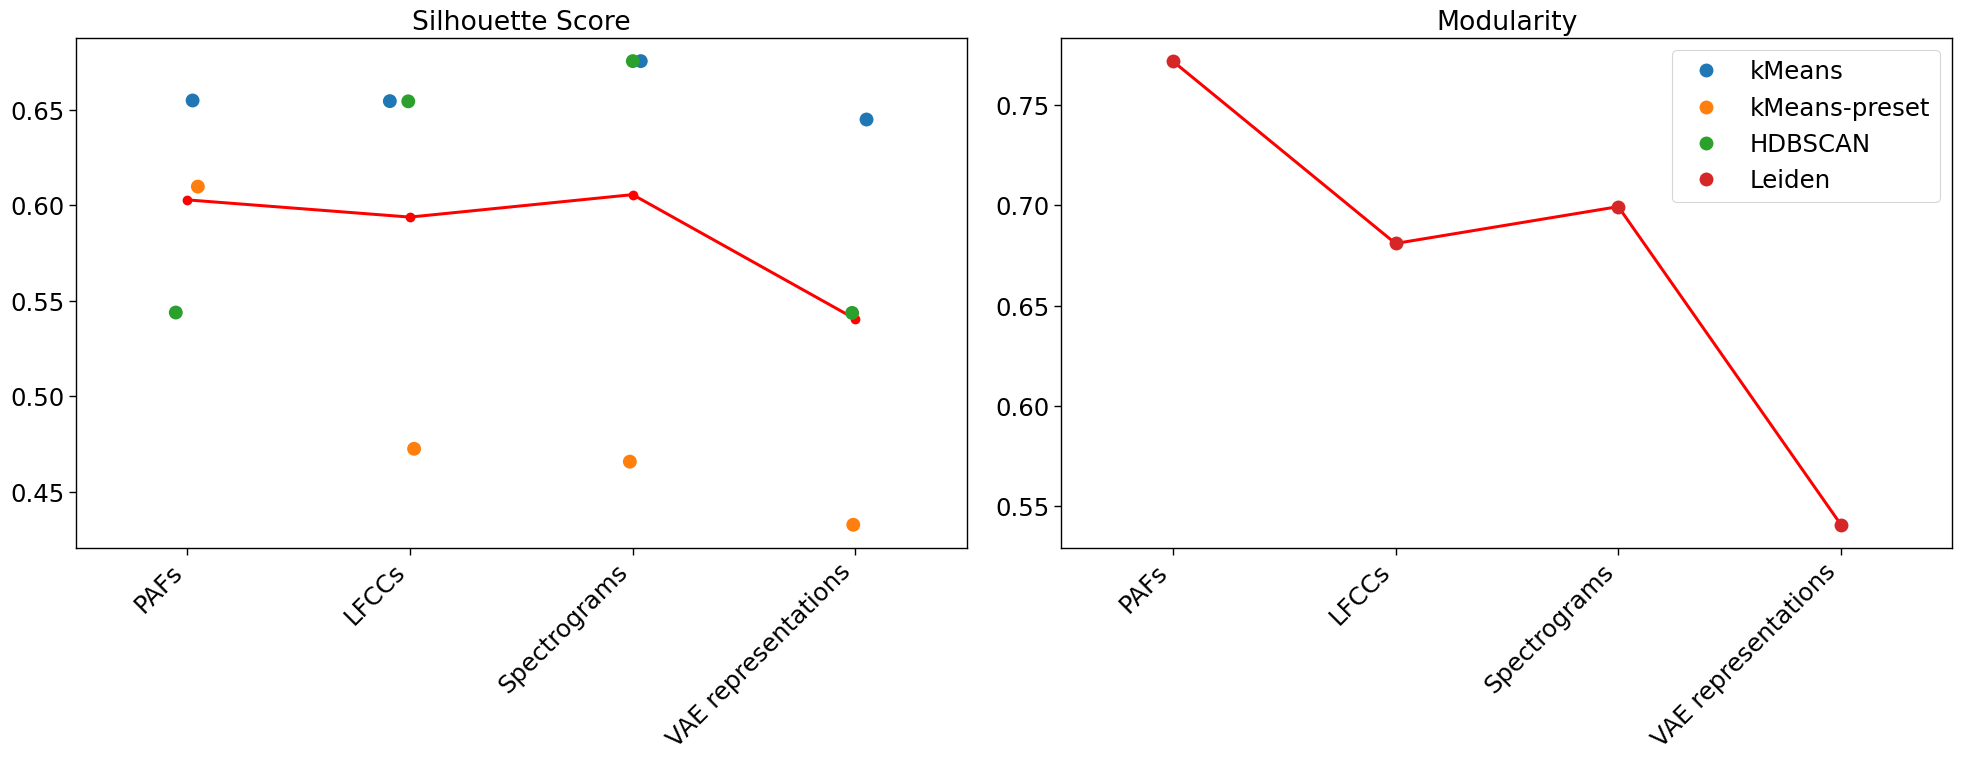

In [120]:
fig, axs = plt.subplots(ncols=2, figsize=(20, 8))

columns = ["Silhouette Score", "Modularity"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        legend=(True if i == len(columns)-1 else False)
    )
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=clusterability_results, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="red"
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

##### True labels vs predicted labels

In [92]:
rows = []
for representation in representation_keys:
    for algorithm in algorithm_keys:

        v_measure, st_err, ci_low, ci_high, p_value, chance_level = _v_measure_against_chance(
            clusters_dict["true_labels"], 
            clusters_dict[representation][algorithm], 
            plot=False)
        
        rows.append([
            representation,
            algorithm,
            v_measure,
            st_err,
            ci_low,
            ci_high,
            p_value,
            chance_level, 
            homogeneity_score(clusters_dict["true_labels"], clusters_dict[representation][algorithm]),
            completeness_score(clusters_dict["true_labels"], clusters_dict[representation][algorithm]),
            adjusted_rand_score(clusters_dict["true_labels"], clusters_dict[representation][algorithm])
        ])

true_vs_pred_df = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm", "V measure", "st_err", "ci_low", "ci_high", "p-value", "Chance level", "Homogeneity", "Completeness", "Adj. RI"]
)

true_vs_pred_df

,Representation,Algorithm,V measure,st_err,ci_low,ci_high,p-value,Chance level,Homogeneity,Completeness,Adj. RI
0,PAFs,kMeans,0.702000,0.009701,0.681038,0.718252,0.0,0.002392,0.677220,0.725789,0.675051
1,PAFs,kMeans-preset,0.677626,0.009323,0.652956,0.691474,0.0,0.002852,0.677932,0.673278,0.620176
2,PAFs,HDBSCAN,0.668266,0.009965,0.642288,0.682573,0.0,0.002407,0.629800,0.707767,0.620307
3,PAFs,Leiden,0.619533,0.008130,0.599295,0.628374,0.0,0.004540,0.695826,0.553295,0.530793
4,LFCCs,kMeans,0.453435,0.009382,0.433366,0.469711,0.0,0.000824,0.316524,0.793078,0.312277
5,LFCCs,kMeans-preset,0.512124,0.009375,0.490469,0.525572,0.0,0.002865,0.514881,0.504166,0.447817
6,LFCCs,HDBSCAN,0.454296,0.009519,0.432329,0.470030,0.0,0.000793,0.316984,0.794370,0.312616
7,LFCCs,Leiden,0.468634,0.008266,0.446850,0.476932,0.0,0.004107,0.517979,0.421754,0.322907
8,Spectrograms,kMeans,0.568519,0.010488,0.545143,0.585738,0.0,0.001432,0.448464,0.771152,0.415223
9,Spectrograms,kMeans-preset,0.492521,0.009044,0.467348,0.505102,0.0,0.002815,0.497829,0.482825,0.414313


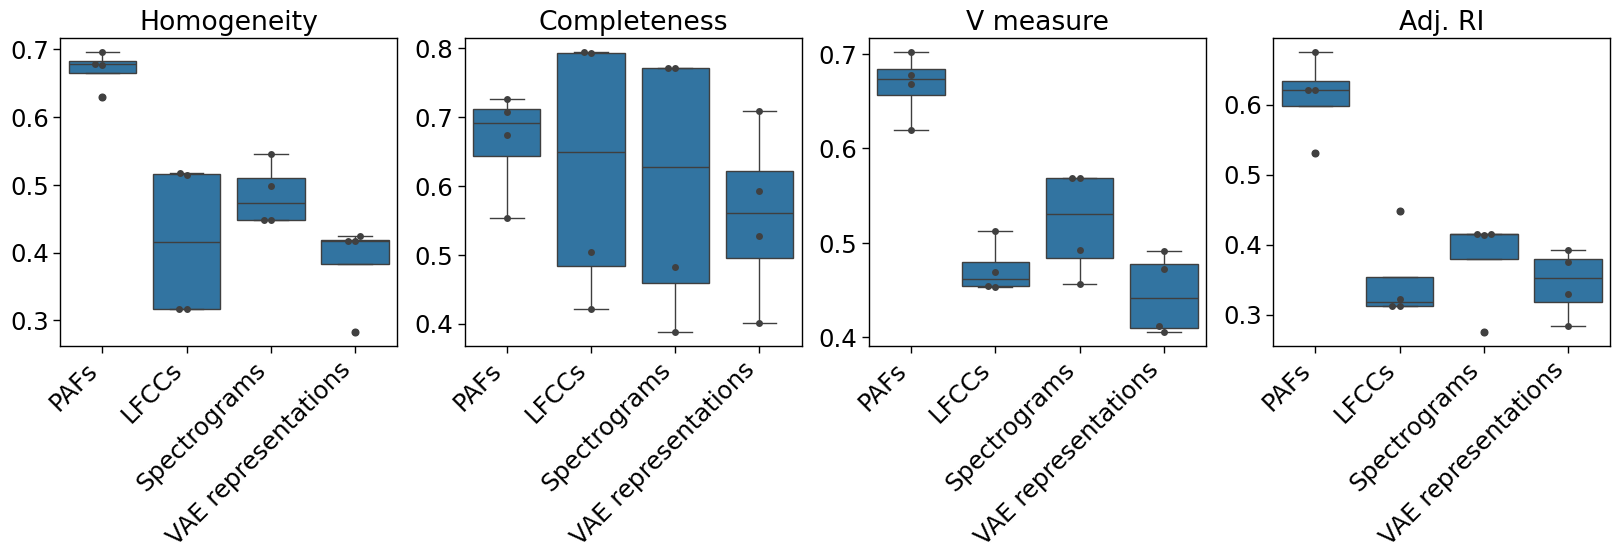

In [102]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/04.0-clusters-vs-labels-metrics/cassins-cluster-label-performance.ipynb
sns.set_context("paper", font_scale=2)
fig, axs = plt.subplots(ncols = 4, figsize=(20,4))

for i, column in enumerate(["Homogeneity", "Completeness", "V measure", "Adj. RI"]):
    sns.boxplot(x="Representation", y=column, data=true_vs_pred_df, ax=axs[i])
    sns.swarmplot(x="Representation", y=column, data=true_vs_pred_df, ax=axs[i], color=".25")
    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')
    axs[i].set_title(column)

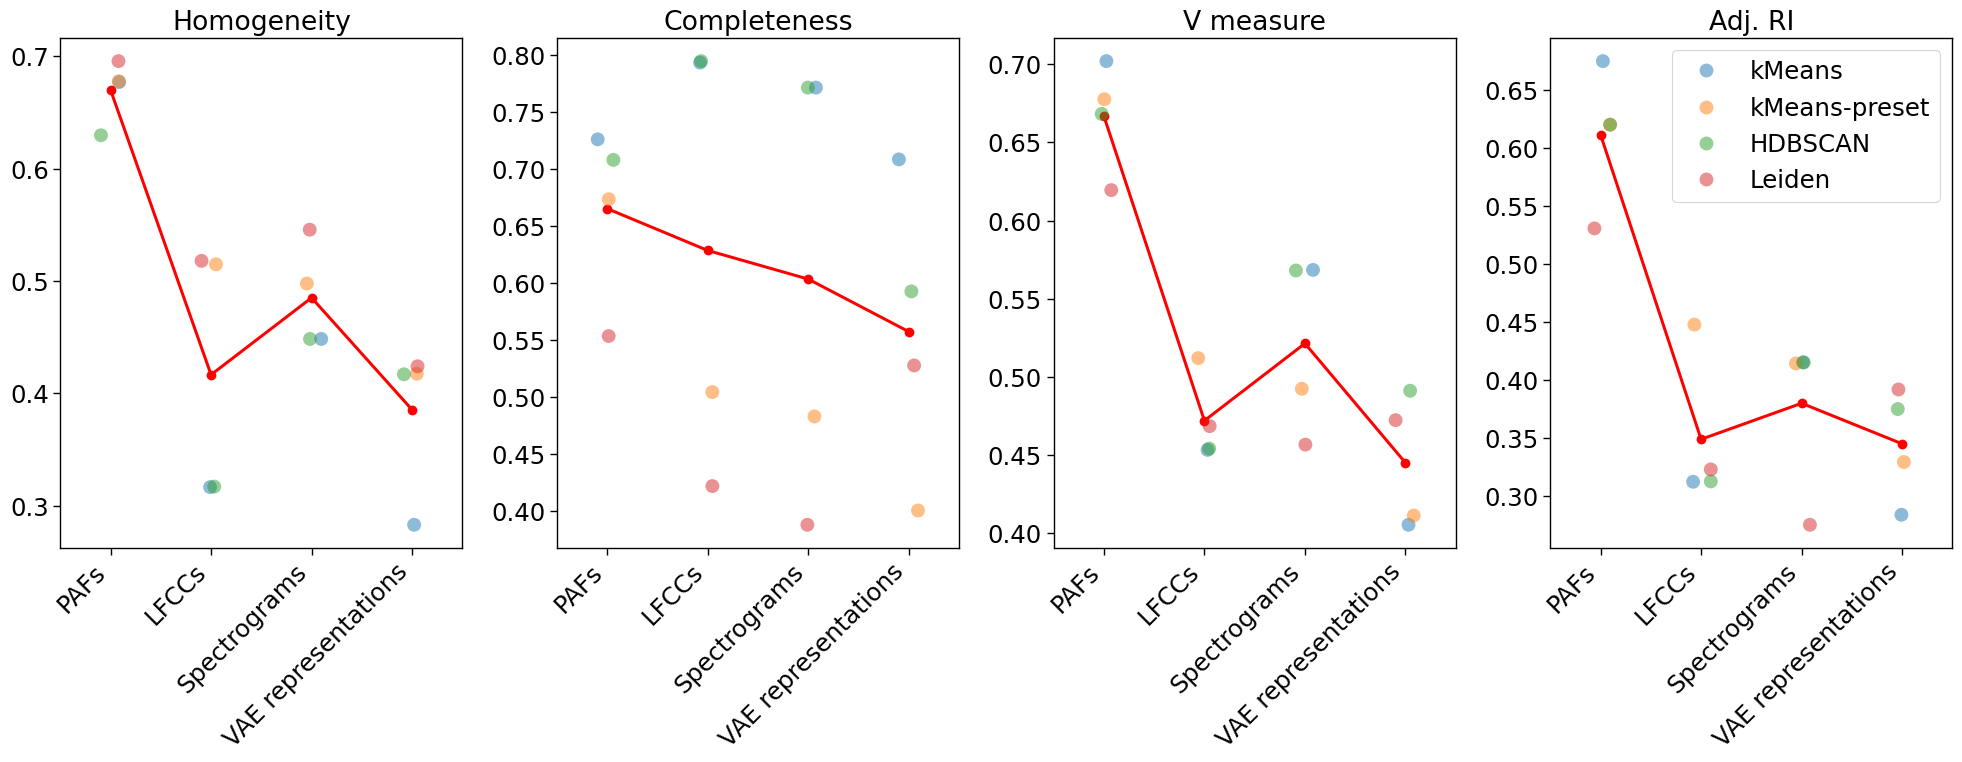

In [131]:
fig, axs = plt.subplots(ncols=4, figsize=(20, 8))

columns = ["Homogeneity", "Completeness", "V measure", "Adj. RI"]
for i, column in enumerate(columns):
    # Raw data points
    sns.stripplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df, 
        ax=axs[i], 
        jitter=True, 
        size=10, 
        hue="Algorithm", 
        alpha=0.5, 
        legend=(True if i == len(columns)-1 else False)
    )
    # Mean points
    sns.pointplot(
        x="Representation", 
        y=column, 
        data=true_vs_pred_df, 
        ax=axs[i], 
        errorbar=None,
        markers="o", 
        color="red"
    )

    axs[i].set_xticks(range(len(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'])))
    axs[i].set_xticklabels(['PAFs', 'LFCCs', 'Spectrograms', 'VAE representations'], rotation=45, ha='right')
    axs[i].set_title(column)
    axs[i].set_xlabel('')
    axs[i].set_ylabel('')

plt.tight_layout()
plt.show()

In [130]:
# Generate LaTeX Table
latex_table = true_vs_pred_df.to_latex(
    index=True,
    multirow=True,
    caption="Clustering Metrics for Representations",
    label="tab:clustering_metrics",
    na_rep="---",
)

print(latex_table)

\begin{table}
\caption{Clustering Metrics for Representations}
\label{tab:clustering_metrics}
\begin{tabular}{lllrrrrrrrrr}
\toprule
 & Representation & Algorithm & V measure & st_err & ci_low & ci_high & p-value & Chance level & Homogeneity & Completeness & Adj. RI \\
\midrule
0 & PAFs & kMeans & 0.702000 & 0.009701 & 0.681038 & 0.718252 & 0.000000 & 0.002392 & 0.677220 & 0.725789 & 0.675051 \\
1 & PAFs & kMeans-preset & 0.677626 & 0.009323 & 0.652956 & 0.691474 & 0.000000 & 0.002852 & 0.677932 & 0.673278 & 0.620176 \\
2 & PAFs & HDBSCAN & 0.668266 & 0.009965 & 0.642288 & 0.682573 & 0.000000 & 0.002407 & 0.629800 & 0.707767 & 0.620307 \\
3 & PAFs & Leiden & 0.619533 & 0.008130 & 0.599295 & 0.628374 & 0.000000 & 0.004540 & 0.695826 & 0.553295 & 0.530793 \\
4 & LFCCs & kMeans & 0.453435 & 0.009382 & 0.433366 & 0.469711 & 0.000000 & 0.000824 & 0.316524 & 0.793078 & 0.312277 \\
5 & LFCCs & kMeans-preset & 0.512124 & 0.009375 & 0.490469 & 0.525572 & 0.000000 & 0.002865 & 0.514881 & 0.50416

#### Compare algorithms

In [128]:
algorithm_keys_wo_leiden = ["kMeans", "kMeans-preset", "HDBSCAN"]
rows = []
for representation in representation_keys:
    for algorithm_a, algorithm_b in itertools.product(algorithm_keys_wo_leiden, algorithm_keys_wo_leiden):
        if algorithm_a == algorithm_b:
            continue
        krusk_res = _silhouette_across_embeddings(clusters_dict[representation][algorithm_a], clusters_dict[representation][algorithm_b], clusters_dict[representation]["embeddings"])
        rows.append([
            representation, 
            algorithm_a, 
            algorithm_b,
            krusk_res.statistic, 
            krusk_res.pvalue])

silhouette_scores_across_results = pd.DataFrame(
    rows, 
    columns=["Representation", "Algorithm a", "Algorithm b", "Silhouette score - Kruskal statistic", "Silhouette score - Kruskal p-value"]
)

silhouette_scores_across_results

,Representation,Algorithm a,Algorithm b,Silhouette score - Kruskal statistic,Silhouette score - Kruskal p-value
0,PAFs,kMeans,kMeans-preset,168.401865,1.652816e-38
1,PAFs,kMeans,HDBSCAN,261.579166,7.767829e-59
2,PAFs,kMeans-preset,kMeans,168.401865,1.652816e-38
3,PAFs,kMeans-preset,HDBSCAN,44.614534,2.399042e-11
4,PAFs,HDBSCAN,kMeans,261.579166,7.767829e-59
5,PAFs,HDBSCAN,kMeans-preset,44.614534,2.399042e-11
6,LFCCs,kMeans,kMeans-preset,1652.166845,0.000000e+00
7,LFCCs,kMeans,HDBSCAN,0.000033,9.953969e-01
8,LFCCs,kMeans-preset,kMeans,1652.166845,0.000000e+00
9,LFCCs,kMeans-preset,HDBSCAN,1651.664442,0.000000e+00


In [ ]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/06.0-neural-networks/starling_figs/Starling-VAE2-128.ipynb
# vae

In [ ]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/09.0-clusterability/make-clusterability-plot-convex-hull-indvs-final.ipynb
# hopkins

In [ ]:
# https://github.com/timsainb/avgn_paper/blob/63e25ca535a230f96b7fb1017728ead6ee0bf36b/notebooks/04.0-clusters-vs-labels-metrics/BF-koumura-cluster-label-performance.ipynb
# v measure

## print results to latex table

In [ ]:
# # Generate LaTeX Table
# latex_table = df_for_latex.to_latex(
#     index=True,
#     multirow=True,
#     caption="Clustering Metrics for Representations",
#     label="tab:clustering_metrics",
#     na_rep="---",
# )

# print(latex_table.replace("[t]{4}{*}", ""))